In [1]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt

import random
import urllib.request
from tqdm import tqdm
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split


# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
# Download data and extract
samples_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=samples.hdf5'
test_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=test.hdf5'
train_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=train.hdf5'
validation_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=validation.hdf5'

urllib.request.urlretrieve(samples_dir, 'samples.hdf5')
urllib.request.urlretrieve(test_dir, 'test.hdf5')
urllib.request.urlretrieve(train_dir, 'train.hdf5')
urllib.request.urlretrieve(validation_dir, 'validation.hdf5')

('validation.hdf5', <http.client.HTTPMessage at 0x7dcfe8faacc0>)

In [3]:
sample_data_path = 'samples.hdf5'

data = h5py.File(sample_data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [4]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

Taille des signaux : (200, 2048, 2)
Taille des SNR : (200,)
Taille des labels : (200,)


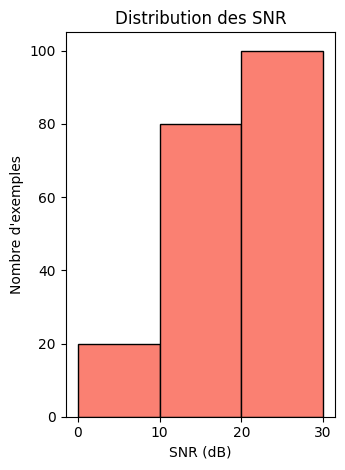

[-0.7017382  -0.26651698  0.48746282 ... -0.4726788  -1.5107473
 -0.27641958]


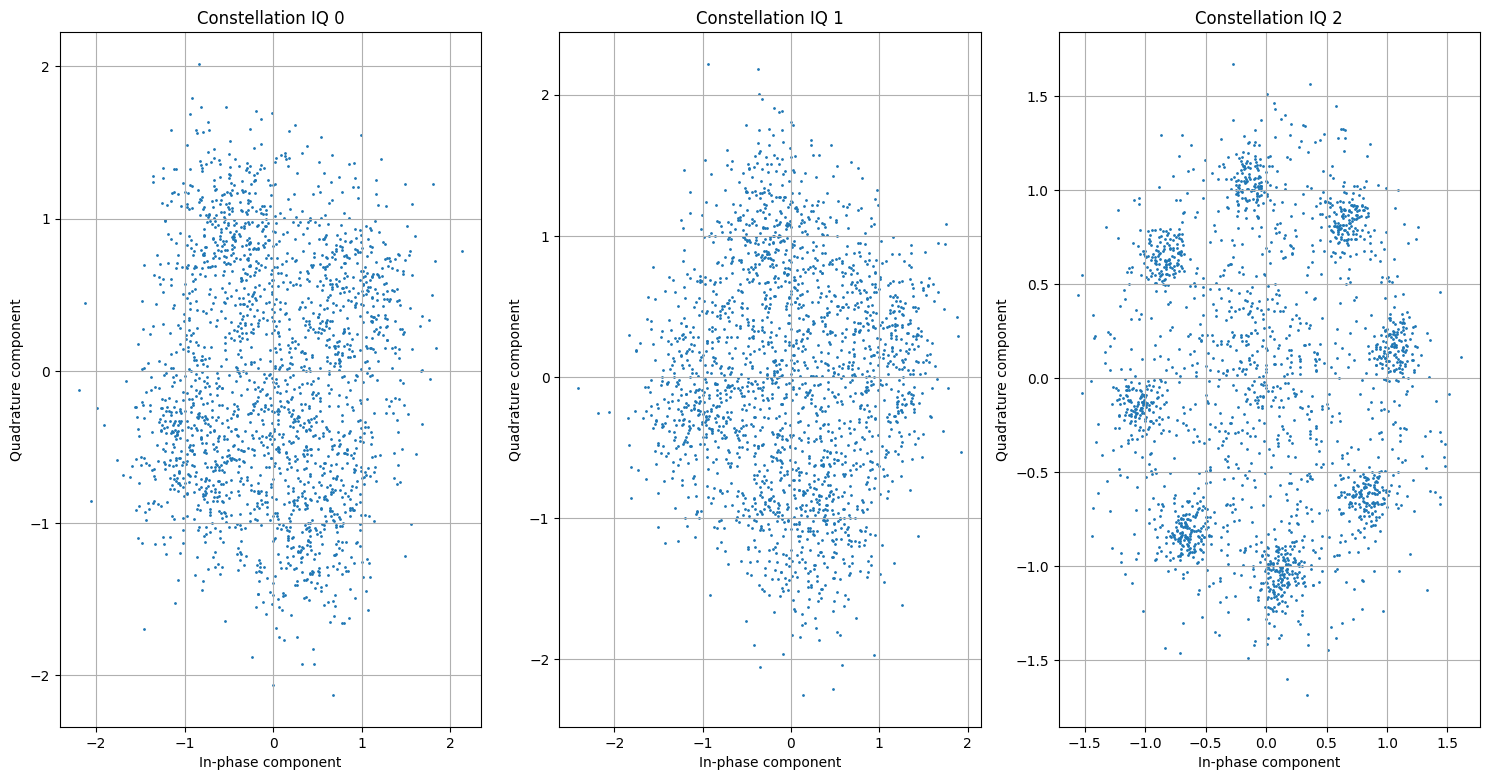

Text(0.5, 1.0, 'Distribution des classes')

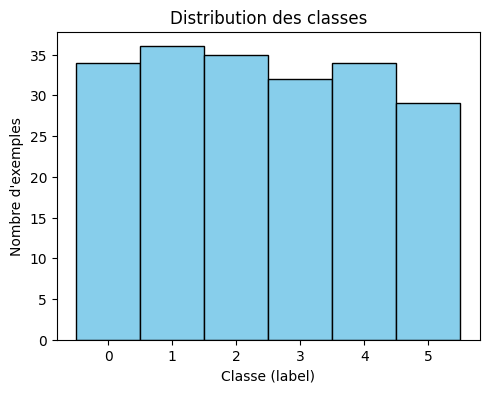

In [5]:
with h5py.File(sample_data_path, 'r') as data:
    signals = np.array(data['signaux'])      # shape: (N, 2, 2048)
    snr = np.array(data['snr'])              # shape: (N,)
    labels_id = np.array(data['labels'])     # shape: (N,)

# 1. Observer la taille des données
print("Taille des signaux :", signals.shape)
print("Taille des SNR :", snr.shape)
print("Taille des labels :", labels_id.shape)

plt.subplot(1, 2, 2)
plt.hist(snr, bins=np.unique(snr), color='salmon', edgecolor='k')
plt.xlabel("SNR (dB)")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution des SNR")
plt.tight_layout()
plt.show()

print(signals[1, :, 0])  # Composante I du signal 1

# 3. Visualisation de quelques signaux
n_examples = 3
plt.figure(figsize=(15, 15))
for i in range(n_examples):
    idx = i  # ou choisir des indices spécifiques
    plt.subplot(2, n_examples, n_examples+i+1)
    plt.scatter(signals[idx, :, 0], signals[idx, :, 1], s=1)
    plt.title(f"Constellation IQ {idx}")
    plt.xlabel("In-phase component")
    plt.ylabel("Quadrature component")
    plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Distribution des classes et des SNR
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(labels_id, bins=np.arange(labels_id.min(), labels_id.max()+2)-0.5, color='skyblue', edgecolor='k')
plt.xlabel("Classe (label)")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution des classes")


## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, label_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        with h5py.File(path_to_data, 'r') as data:
            self.signals = np.array(data['signaux'])      # shape: (N, 2, 2048)
            self.labels = np.array(data['labels'])        # shape: (N,)

        # Ensure shape is (N, C, T) = (N, 2, 2048)
        if self.signals.shape[1] == 2:
            # Already (N, 2, T)
            self.signals = self.signals
        elif self.signals.shape[-1] == 2:
            # (N, T, 2) -> (N, 2, T)
            self.signals = np.transpose(self.signals, (0, 2, 1))
        else:
            raise ValueError(f"Unexpected signals shape {self.signals.shape}, cannot find channel dimension 2.")

        # Conversion en tensors pour PyTorch
        self.signals = torch.tensor(self.signals, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.signals[i], self.labels[i]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [7]:
dataset = MyDataset(sample_data_path)
x0 = dataset[0]  # Premier signal
print("Signal shape:", x0[0].shape)
x1 = dataset[1]  # Deuxième signal
print("Signal shape:", x1[0].shape)

Signal shape: torch.Size([2, 2048])
Signal shape: torch.Size([2, 2048])


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [8]:
dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [9]:
# Iterate on the DataLoader
for batch_idx, (signals_batch, labels_batch) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print("  Signals batch shape:", signals_batch.shape)
    print("  Labels batch shape:", labels_batch.shape)
    if batch_idx == 2:
        break

Batch 0:
  Signals batch shape: torch.Size([10, 2, 2048])
  Labels batch shape: torch.Size([10])
Batch 1:
  Signals batch shape: torch.Size([10, 2, 2048])
  Labels batch shape: torch.Size([10])
Batch 2:
  Signals batch shape: torch.Size([10, 2, 2048])
  Labels batch shape: torch.Size([10])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [10]:
class DumbModel(torch.nn.Module):
    def __init__(self, in_channels, n_classes=6):
        super(DumbModel, self).__init__()
        self.fc = torch.nn.Linear(in_channels, n_classes)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # x: [B, C, T]
        x = x.mean(dim=-1)  # [B, C]
        x = self.fc(x)      # [B, n_classes]
        x = self.softmax(x)
        return x

Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [11]:
dumb_model = DumbModel(in_channels=2, n_classes=6)
# Do a pass with batch of data to test dimensions
signals_batch, labels_batch = next(iter(dataloader))
print("Signals batch shape:", signals_batch.shape)  # [B, 2, 2048]
outputs = dumb_model(signals_batch)
print("Output shape:", outputs.shape)  # [B, n_classes]

Signals batch shape: torch.Size([10, 2, 2048])
Output shape: torch.Size([10, 6])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [12]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [13]:
n_params_dumb = count_n_param(dumb_model)
print("Number of parameters in DumbModel:", n_params_dumb)

Number of parameters in DumbModel: 18


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [14]:
# Load full dataset
train_data_path = "train.hdf5"
full_dataset = MyDataset(train_data_path)

# We use a validation ratio of 20%
validation_ratio = 0.2
n_total   = len(full_dataset)
n_val     = int(n_total * validation_ratio)
n_train   = n_total - n_val
# Random split training and validation
train_dataset, valid_dataset = random_split(full_dataset, [n_train, n_val])

# Define batch size and create data loaders
batch_size = 64
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = DumbModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_path = "dumb_model.pth"
model.to(device)

def batch_accuracy(log_probs, targets):
    preds = log_probs.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []
n_epochs = 20
for epoch in range(n_epochs):

    # Training loop
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        # logging
        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation loop
    if epoch == 0 or (epoch + 1) % 5 == 0:
        model.eval()
        running_loss_valid = 0.0
        running_acc_valid  = 0.0
        n_valid_samples    = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader_valid:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                batch_y_predicted = model(batch_x)
                l = loss_fn(batch_y_predicted, batch_y)

                batch_size = batch_x.size(0)
                running_loss_valid += l.item() * batch_size
                running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
                n_valid_samples    += batch_size

        epoch_valid_loss = running_loss_valid / n_valid_samples
        epoch_valid_acc  = running_acc_valid  / n_valid_samples
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)

        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

# Sauvegarde du modèle
torch.save(model, model_path)
print("Model saved to:", model_path)

Using device: cuda
Epoch 0/20 | train_loss=1.8383, valid_loss=1.8148, train_acc=0.1631, valid_acc=0.1587
Epoch 4/20 | train_loss=1.7916, valid_loss=1.7916, train_acc=0.1720, valid_acc=0.1678
Epoch 9/20 | train_loss=1.7916, valid_loss=1.7915, train_acc=0.1723, valid_acc=0.1687
Epoch 14/20 | train_loss=1.7915, valid_loss=1.7915, train_acc=0.1715, valid_acc=0.1688
Epoch 19/20 | train_loss=1.7915, valid_loss=1.7915, train_acc=0.1705, valid_acc=0.1675
Model saved to: dumb_model.pth


Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [16]:
loaded_model = torch.load(model_path, map_location=device, weights_only=False)
loaded_model.to(device)
loaded_model.eval()

# Take a batch from your dataloader (train or valid)
signals_batch, labels_batch = next(iter(dataloader_valid))
signals_batch = signals_batch.to(device)
labels_batch  = labels_batch.to(device)

with torch.no_grad():
    outputs = loaded_model(signals_batch)

print("Signals batch shape:", signals_batch.shape)
print("Outputs shape:", outputs.shape)

# Checking some 'predictions'
preds = outputs.argmax(dim=-1)
print("Predictions:", preds[:10].cpu().numpy())
print("True labels:", labels_batch[:10].cpu().numpy())

Signals batch shape: torch.Size([64, 2, 2048])
Outputs shape: torch.Size([64, 6])
Predictions: [0 0 0 2 1 0 0 0 0 0]
True labels: [0 5 4 5 5 3 2 4 0 1]


## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

As we have saw in the lecture about vocal recognition, there are three stages that comprise the signal classification:
- Temporal feature extraction
- Temporal dimension contraction
- Classification

We also saw that the loss function used is normally the negative log likelihood.

**Design of our Convolutional NN architecture**
For the temporal **feature extraction** we will use 1D convolutional layers, by stacking several convs with the ReLU activation function. The idea is that the first conv layers behave like local time-frequency filters while deeper conv layers will comine them to form more abstract patterns (as it was done for speech).

After temporal feature extraction we must reduce the time dimension by pooling. There are two approaches for this:
- Local contraction using `MaxPool1d(kernel_size=2)` after each conv layer, so that there is a local temporal downsampling.
- Global contaction (using `x.mean(dim=-1)`).
For this architecture we will use the latter.

For the classification layer we will just use a MLP followed by a softmax.

In [ ]:
"""
Iteration 1:
- Small kernel size
- Channels per layer [16, 32, 64]
- Smaller dense layer
"""
class ConvModel(nn.Module):
    def __init__(self, in_channels=2, n_classes=6):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # DONWNSAMPLING BLOCK
        x = x.mean(dim=-1)

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = ConvModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model_path = "conv1_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(log_probs, targets):
    preds = log_probs.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []
n_epochs = 60
for epoch in tqdm(range(n_epochs)):

    # Training loop
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        # logging
        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)


    # Validation loop
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

# Save the model
torch.save(model.state_dict(), model_path)
print("Model saved to:", model_path)

Using device: cuda
Number of parameters in ConvModel: 10166


  2%|▏         | 1/60 [00:03<03:29,  3.55s/it]

Epoch 0/60 | train_loss=1.4784, valid_loss=1.1310, train_acc=0.2831, valid_acc=0.4387


  8%|▊         | 5/60 [00:14<02:36,  2.84s/it]

Epoch 4/60 | train_loss=0.6758, valid_loss=0.6511, train_acc=0.5991, valid_acc=0.5822


 17%|█▋        | 10/60 [00:29<02:23,  2.87s/it]

Epoch 9/60 | train_loss=0.6336, valid_loss=0.6208, train_acc=0.6047, valid_acc=0.6197


 25%|██▌       | 15/60 [00:43<02:07,  2.83s/it]

Epoch 14/60 | train_loss=0.6161, valid_loss=0.6009, train_acc=0.6342, valid_acc=0.6552


 33%|███▎      | 20/60 [00:57<01:53,  2.83s/it]

Epoch 19/60 | train_loss=0.5757, valid_loss=0.5543, train_acc=0.6662, valid_acc=0.6883


 42%|████▏     | 25/60 [01:12<01:39,  2.83s/it]

Epoch 24/60 | train_loss=0.5508, valid_loss=0.5351, train_acc=0.6744, valid_acc=0.6785


 50%|█████     | 30/60 [01:26<01:25,  2.85s/it]

Epoch 29/60 | train_loss=0.5312, valid_loss=0.5147, train_acc=0.6810, valid_acc=0.6972


 58%|█████▊    | 35/60 [01:40<01:10,  2.84s/it]

Epoch 34/60 | train_loss=0.5240, valid_loss=0.5068, train_acc=0.6864, valid_acc=0.6987


 67%|██████▋   | 40/60 [01:54<00:57,  2.85s/it]

Epoch 39/60 | train_loss=0.5068, valid_loss=0.4992, train_acc=0.6944, valid_acc=0.6980


 75%|███████▌  | 45/60 [02:08<00:42,  2.84s/it]

Epoch 44/60 | train_loss=0.4887, valid_loss=0.4793, train_acc=0.7051, valid_acc=0.7127


 83%|████████▎ | 50/60 [02:23<00:28,  2.84s/it]

Epoch 49/60 | train_loss=0.4728, valid_loss=0.4675, train_acc=0.7134, valid_acc=0.7182


 92%|█████████▏| 55/60 [02:37<00:14,  2.84s/it]

Epoch 54/60 | train_loss=0.4671, valid_loss=0.4830, train_acc=0.7140, valid_acc=0.7013


100%|██████████| 60/60 [02:51<00:00,  2.86s/it]

Epoch 59/60 | train_loss=0.4643, valid_loss=0.4583, train_acc=0.7182, valid_acc=0.7263
Model saved to: conv1_model.pth


In [ ]:
print("Final validation accuracy:", valid_accs[-1])
print("Final validation loss:", valid_losses[-1])

Final validation accuracy: 0.7263333336512248
Final validation loss: 0.4582960122426351


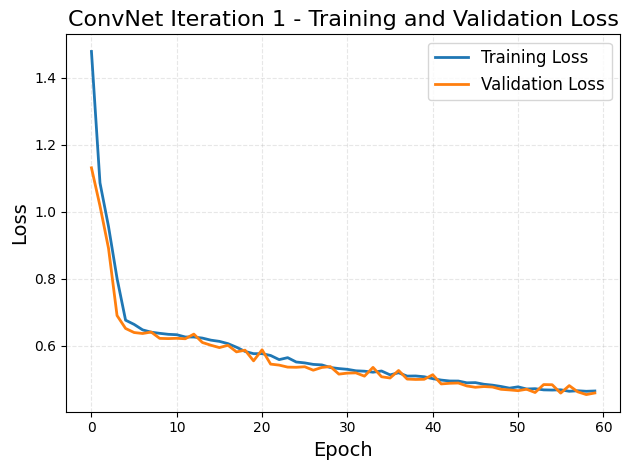

In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 1 - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [17]:
"""
Iteration 2:
- Larger kernel size: size 7, padding 3
- Channels per layer [32, 64, 128]
- Larger dense layer
"""
class ConvModel2(nn.Module):
    def __init__(self, in_channels=2, n_classes=6):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.ReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.ReLU(),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # DONWNSAMPLING BLOCK
        x = x.mean(dim=-1)

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = ConvModel2(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model_path = "conv2_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(log_probs, targets):
    preds = log_probs.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []
n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # Training loop
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        # logging
        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation loop
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

# Save the model
torch.save(model.state_dict(), model_path)
print("Model saved to:", model_path)

Using device: cuda
Number of parameters in ConvModel: 80998


  1%|▏         | 1/80 [00:10<13:19, 10.12s/it]

Epoch 0/80 | train_loss=1.3736, valid_loss=1.1326, train_acc=0.2864, valid_acc=0.3853


  6%|▋         | 5/80 [00:48<12:05,  9.67s/it]

Epoch 4/80 | train_loss=0.7535, valid_loss=0.6685, train_acc=0.5805, valid_acc=0.5862


 12%|█▎        | 10/80 [01:35<11:03,  9.47s/it]

Epoch 9/80 | train_loss=0.6311, valid_loss=0.6232, train_acc=0.6079, valid_acc=0.5943


 19%|█▉        | 15/80 [02:23<10:13,  9.44s/it]

Epoch 14/80 | train_loss=0.5720, valid_loss=0.6888, train_acc=0.6659, valid_acc=0.5652


 25%|██▌       | 20/80 [03:10<09:23,  9.40s/it]

Epoch 19/80 | train_loss=0.5516, valid_loss=0.5685, train_acc=0.6777, valid_acc=0.6585


 31%|███▏      | 25/80 [03:56<08:34,  9.36s/it]

Epoch 24/80 | train_loss=0.5428, valid_loss=0.5652, train_acc=0.6812, valid_acc=0.6782


 38%|███▊      | 30/80 [04:43<07:47,  9.34s/it]

Epoch 29/80 | train_loss=0.5250, valid_loss=0.5327, train_acc=0.6922, valid_acc=0.6933


 44%|████▍     | 35/80 [05:30<06:59,  9.32s/it]

Epoch 34/80 | train_loss=0.5227, valid_loss=0.5168, train_acc=0.6920, valid_acc=0.7067


 50%|█████     | 40/80 [06:16<06:11,  9.29s/it]

Epoch 39/80 | train_loss=0.5171, valid_loss=0.5101, train_acc=0.6918, valid_acc=0.6930


 56%|█████▋    | 45/80 [07:03<05:23,  9.26s/it]

Epoch 44/80 | train_loss=0.5035, valid_loss=0.5066, train_acc=0.7017, valid_acc=0.7082


 62%|██████▎   | 50/80 [07:49<04:36,  9.23s/it]

Epoch 49/80 | train_loss=0.5022, valid_loss=0.4968, train_acc=0.7005, valid_acc=0.7115


 69%|██████▉   | 55/80 [08:35<03:50,  9.21s/it]

Epoch 54/80 | train_loss=0.4991, valid_loss=0.4992, train_acc=0.7064, valid_acc=0.7098


 75%|███████▌  | 60/80 [09:21<03:03,  9.18s/it]

Epoch 59/80 | train_loss=0.4949, valid_loss=0.4915, train_acc=0.7057, valid_acc=0.7147


 81%|████████▏ | 65/80 [10:06<02:17,  9.17s/it]

Epoch 64/80 | train_loss=0.4940, valid_loss=0.5091, train_acc=0.7077, valid_acc=0.7040


 88%|████████▊ | 70/80 [10:52<01:31,  9.16s/it]

Epoch 69/80 | train_loss=0.4917, valid_loss=0.4924, train_acc=0.7100, valid_acc=0.7105


 94%|█████████▍| 75/80 [11:38<00:45,  9.14s/it]

Epoch 74/80 | train_loss=0.4829, valid_loss=0.4876, train_acc=0.7130, valid_acc=0.7202


100%|██████████| 80/80 [12:23<00:00,  9.30s/it]

Epoch 79/80 | train_loss=0.4892, valid_loss=0.4876, train_acc=0.7064, valid_acc=0.6942
Model saved to: conv2_model.pth


In [19]:
print("Final validation accuracy:", valid_accs[-1])
print("Final validation loss:", valid_losses[-1])

Final validation accuracy: 0.6941666666666667
Final validation loss: 0.4875665863355001


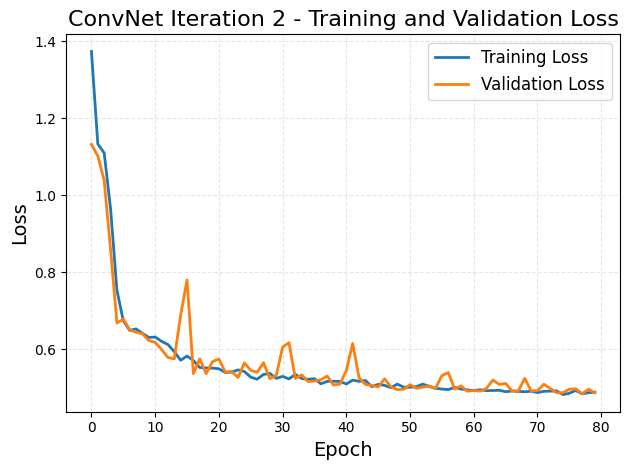

In [20]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 2 - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


We can see that increasing the receptive field from 22 samples to 50 and the model weights from 10k to 80k has small effect in the results obtained with the accuracy going from 70% to 73%. However since the training times are still in the order of minutes we will use this changes for the next iteration.

In [21]:
"""
Iteration 3:
- Larger kernel size: size 7, padding 3
- Channels per layer [32, 64, 128]
- Larger dense layer
- Dropout 0.1
- Batch normalization
- Maxpool after each conv block
- Adding learning rate scheduler
"""
class Conv3Model(nn.Module):
    def __init__(self, in_channels=2, n_classes=6):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # DONWNSAMPLING BLOCK
        x = x.mean(dim=-1)

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = Conv3Model(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

model_path = "conv3_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

best_valid_loss = float('inf')
best_epoch = -1

n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # TRAINING
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #  VALIDATION
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    scheduler.step(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

print(f"Best model was at epoch {best_epoch} "
      f"with valid_loss={best_valid_loss:.4f}")


Using device: cuda
Number of parameters in ConvModel: 81446


  1%|▏         | 1/80 [00:07<10:12,  7.76s/it]

New best model at epoch 0 | valid_loss=1.6002
Epoch 0/80 | train_loss=1.2916, valid_loss=1.6002, train_acc=0.3278, valid_acc=0.3677


  2%|▎         | 2/80 [00:15<09:53,  7.61s/it]

New best model at epoch 1 | valid_loss=0.6343


  6%|▋         | 5/80 [00:36<09:01,  7.23s/it]

Epoch 4/80 | train_loss=0.5745, valid_loss=1.5357, train_acc=0.6707, valid_acc=0.4877


  8%|▊         | 6/80 [00:44<09:16,  7.52s/it]

New best model at epoch 5 | valid_loss=0.5502


 10%|█         | 8/80 [00:58<08:43,  7.26s/it]

New best model at epoch 7 | valid_loss=0.5319


 12%|█▎        | 10/80 [01:13<08:31,  7.30s/it]

New best model at epoch 9 | valid_loss=0.4801
Epoch 9/80 | train_loss=0.5049, valid_loss=0.4801, train_acc=0.7011, valid_acc=0.7035


 19%|█▉        | 15/80 [01:50<08:16,  7.64s/it]

Epoch 14/80 | train_loss=0.4860, valid_loss=0.5225, train_acc=0.7132, valid_acc=0.6995


 25%|██▌       | 20/80 [02:26<07:16,  7.27s/it]

Epoch 19/80 | train_loss=0.4642, valid_loss=2.5183, train_acc=0.7223, valid_acc=0.5598


 29%|██▉       | 23/80 [02:48<06:55,  7.28s/it]

New best model at epoch 22 | valid_loss=0.4775


 31%|███▏      | 25/80 [03:04<06:54,  7.54s/it]

Epoch 24/80 | train_loss=0.4487, valid_loss=0.7766, train_acc=0.7333, valid_acc=0.6518


 38%|███▊      | 30/80 [03:42<06:12,  7.45s/it]

Epoch 29/80 | train_loss=0.4459, valid_loss=0.9283, train_acc=0.7388, valid_acc=0.6762


 39%|███▉      | 31/80 [03:49<05:54,  7.24s/it]

New best model at epoch 30 | valid_loss=0.4438


 44%|████▍     | 35/80 [04:18<05:27,  7.28s/it]

Epoch 34/80 | train_loss=0.4403, valid_loss=0.5331, train_acc=0.7443, valid_acc=0.7083


 50%|█████     | 40/80 [04:54<04:41,  7.04s/it]

Epoch 39/80 | train_loss=0.4353, valid_loss=1.4321, train_acc=0.7411, valid_acc=0.6080


 56%|█████▋    | 45/80 [05:29<04:08,  7.10s/it]

Epoch 44/80 | train_loss=0.4230, valid_loss=0.9918, train_acc=0.7503, valid_acc=0.6640


 62%|██████▎   | 50/80 [06:04<03:31,  7.04s/it]

Epoch 49/80 | train_loss=0.4196, valid_loss=0.5018, train_acc=0.7537, valid_acc=0.7038


 69%|██████▉   | 55/80 [06:39<02:54,  6.97s/it]

Epoch 54/80 | train_loss=0.4112, valid_loss=0.7748, train_acc=0.7650, valid_acc=0.6687


 75%|███████▌  | 60/80 [07:13<02:18,  6.95s/it]

Epoch 59/80 | train_loss=0.4082, valid_loss=0.4645, train_acc=0.7680, valid_acc=0.7418


 81%|████████▏ | 65/80 [07:48<01:44,  6.94s/it]

New best model at epoch 64 | valid_loss=0.4402
Epoch 64/80 | train_loss=0.4024, valid_loss=0.4402, train_acc=0.7751, valid_acc=0.7523


 88%|████████▊ | 70/80 [08:23<01:08,  6.90s/it]

Epoch 69/80 | train_loss=0.4026, valid_loss=0.4816, train_acc=0.7724, valid_acc=0.7363


 94%|█████████▍| 75/80 [08:58<00:34,  6.95s/it]

Epoch 74/80 | train_loss=0.3997, valid_loss=0.4809, train_acc=0.7772, valid_acc=0.7360


100%|██████████| 80/80 [09:32<00:00,  7.16s/it]

Epoch 79/80 | train_loss=0.3974, valid_loss=0.4548, train_acc=0.7786, valid_acc=0.7513
Training done. Best model was at epoch 64 with valid_loss=0.4402


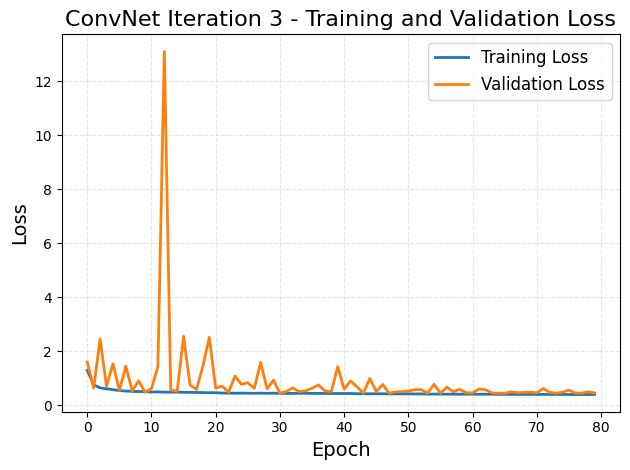

In [38]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 3 - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


We see that using more advances techinques such as dropout, maxpool after each convolutional layer, and reducing the learning rate during training has pushed the accuracy up to 83%. We can also see that the training is less stable, in the sence that the validation loss is changing between different epochs more than before, this is most probably due to the size of the model. Now it's easier for the model to learn and be too confident at some points.

Next, we will use the same convolution block as in the previous architecture for the initial feature extraction. However, one problem of conv layers is that they have a limited receptive field (max 50 in our conv block). Each means they will struggle to capture long-range temporal structures, dependencies over 100s of samples. For that reason we will introduce a recurrent network so that the model has memory over longer time intervals, this also includes some ordering, which is natural in time series. As explained durng the lecture we will use the Gated recurrent Unit (GRU), a simplication of LSTM that limits the number of parameters to allow for faster training and minimize the risk of overfitting.

In [25]:
"""
Iteration 4:
- Larger kernel size: size 7, padding 3
- Channels per layer [32, 64, 128]
- Larger dense layer
- Dropout 0.1
- Batch normalization
- Learning rate scheduler
- Maxpool after each conv block
- GRU
"""
class Conv3GRUModel(nn.Module):
    def __init__(self, in_channels=2, n_classes=6, hidden_rnn=64):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=hidden_rnn,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.fc1 = nn.Linear(2 * hidden_rnn, 64)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # RECURRENT BLOCK
        x = x.permute(0, 2, 1)
        h_out, _ = self.gru(x)
        last = h_out[:, -1, :]

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(last))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = Conv3GRUModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

model_path = "conv3_gru_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

best_valid_loss = float('inf')
best_epoch = -1

n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # TRAINING
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #  VALIDATION
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    scheduler.step(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)
        print(f"New best model at epoch {epoch} | valid_loss={epoch_valid_loss:.4f}")

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

print(f"Best model was at epoch {best_epoch} "
      f"with valid_loss={best_valid_loss:.4f}")

Using device: cuda
Number of parameters in ConvModel: 155942


  1%|▏         | 1/80 [00:08<10:45,  8.16s/it]

New best model at epoch 0 | valid_loss=1.8003
Epoch 0/80 | train_loss=1.3277, valid_loss=1.8003, train_acc=0.2993, valid_acc=0.2783


  2%|▎         | 2/80 [00:16<10:53,  8.38s/it]

New best model at epoch 1 | valid_loss=1.1055


  5%|▌         | 4/80 [00:33<10:33,  8.33s/it]

New best model at epoch 3 | valid_loss=0.9347


  6%|▋         | 5/80 [00:41<10:29,  8.40s/it]

New best model at epoch 4 | valid_loss=0.6376
Epoch 4/80 | train_loss=0.6798, valid_loss=0.6376, train_acc=0.5746, valid_acc=0.5772


  8%|▊         | 6/80 [00:50<10:31,  8.53s/it]

New best model at epoch 5 | valid_loss=0.6357


 10%|█         | 8/80 [01:07<10:06,  8.43s/it]

New best model at epoch 7 | valid_loss=0.6309


 12%|█▎        | 10/80 [01:24<09:46,  8.37s/it]

New best model at epoch 9 | valid_loss=0.6262
Epoch 9/80 | train_loss=0.6450, valid_loss=0.6262, train_acc=0.5906, valid_acc=0.5937


 15%|█▌        | 12/80 [01:43<09:45,  8.61s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 3 GRU - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


We can see that there is a large amount of overfitting. For larger networks (we went from 10k-weight network to 155k) it makes sense to use data augmentation to prevent overfitting. We will use the following transformations to simulate possible realistic variabilities:
- Time misalignment: To simulate imperfect synchronization
- Amplitude variations: To simulate gain variations from the channel
- Noise: Additive Gaussian noise

In [ ]:
def augment_signal(x, max_shift=20, noise_std=0.01, gain_range=(0.8, 1.2)):
    # time shift
    shift = random.randint(-max_shift, max_shift)
    x = torch.roll(x, shifts=shift, dims=-1)
    # random gain
    gain = random.uniform(*gain_range)
    x = x * gain
    # gaussian noise
    noise = torch.randn_like(x) * noise_std
    x = x + noise

    return x

def collate_fn_augment(batch):
    xs, ys = zip(*batch)

    xs_aug = [augment_signal(x.clone()) for x in xs]
    X = torch.stack(xs_aug, dim=0)
    y = torch.tensor(ys, dtype=torch.long)

    return X, y

In [ ]:
# Apply data augmentation only ONLY on training set
dataloader_train = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn_augment
)

dataloader_valid = DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=None
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = Conv3GRUModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

model_path = "conv3_gru_aug_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

best_valid_loss = float('inf')
best_epoch = -1

n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # TRAINING
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #  VALIDATION
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    scheduler.step(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)
        print(f"New best model at epoch {epoch} | valid_loss={epoch_valid_loss:.4f}")

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

print(f"Best model was at epoch {best_epoch} "
      f"with valid_loss={best_valid_loss:.4f}")

In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 3 GRU Aug - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Synthèse de résultats
Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.